<a href="https://colab.research.google.com/github/mayurtummewar/crypto-watermarking/blob/main/completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [2]:
!pip install pywavelets opencv-python

In [3]:
import numpy as np
import pywt
import cv2
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['figure.figsize'] = (6, 6)
np.set_printoptions(suppress=True, precision=4)

In [5]:
WAVELET='db1'
DWT_LEVEL=2
PIXEL_MAX=255

In [20]:
K=0.98
Q=0.02

In [28]:
# XOR-chaos encryption parameters
CHAOS_SEED = 123456      # secret key

In [7]:
def show_image(img, title="", cmap='gray'):
  plt.imshow(img, cmap=cmap)
  plt.title(title)
  plt.axis('off')
  plt.show()

In [8]:
def generate_chaos_key(shape, seed):
    rng = np.random.default_rng(seed)
    return rng.integers(0, 256, size=shape, dtype=np.uint8)

In [9]:
cover = cv2.imread("assets/cameraman_grayscale.png", cv2.IMREAD_GRAYSCALE)
watermark = cv2.imread("assets/sppu_logo.jpg", cv2.IMREAD_GRAYSCALE)
print(cover.shape, watermark.shape)

(256, 256) (300, 413)


In [10]:
coeffs_cover = pywt.wavedec2(
    cover.astype(np.double),
    wavelet=WAVELET,
    level=DWT_LEVEL
)

In [11]:
LL2_cover = coeffs_cover[0]
(LH2_cover, HL2_cover, HH2_cover) = coeffs_cover[1]
(LH1_cover, HL1_cover, HH1_cover) = coeffs_cover[2]

print("LL2 shape:", LL2_cover.shape)

LL2 shape: (64, 64)


In [12]:
coeffs_wm = pywt.wavedec2(
    watermark.astype(np.double),
    wavelet=WAVELET,
    level=DWT_LEVEL
)

LL2_wm = coeffs_wm[0]
print("Original watermark LL2 shape:", LL2_wm.shape)

Original watermark LL2 shape: (75, 104)


In [13]:
LL2_wm_original = LL2_wm.copy()

LL2_wm_resized = cv2.resize(
    LL2_wm,
    (LL2_cover.shape[1], LL2_cover.shape[0]),
    interpolation=cv2.INTER_CUBIC
)

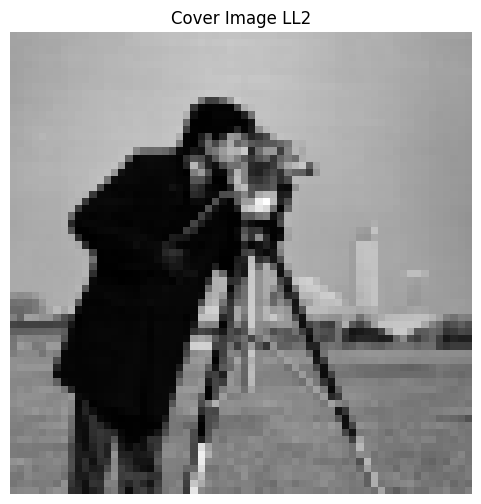

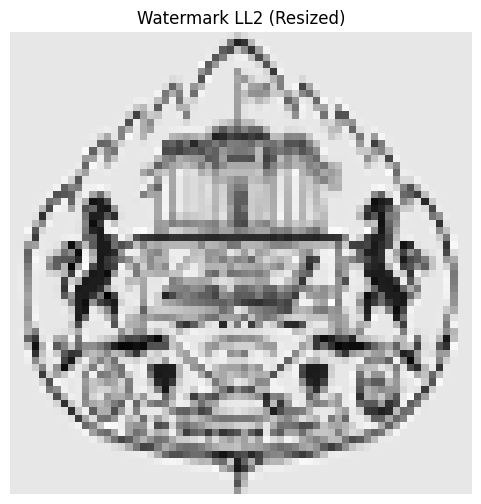

In [14]:
show_image(LL2_cover, "Cover Image LL2")
show_image(LL2_wm_resized, "Watermark LL2 (Resized)")

In [21]:
LL2_embedded = (K * LL2_cover) + (Q * LL2_wm_resized)

In [22]:
coeffs_embedded = [
    LL2_embedded,
    (LH2_cover, HL2_cover, HH2_cover),
    (LH1_cover, HL1_cover, HH1_cover)
]

In [23]:
watermarked_double = pywt.waverec2(
    coeffs_embedded,
    wavelet=WAVELET
)

In [24]:
watermarked = np.clip(watermarked_double, 0, 255).astype(np.uint8)

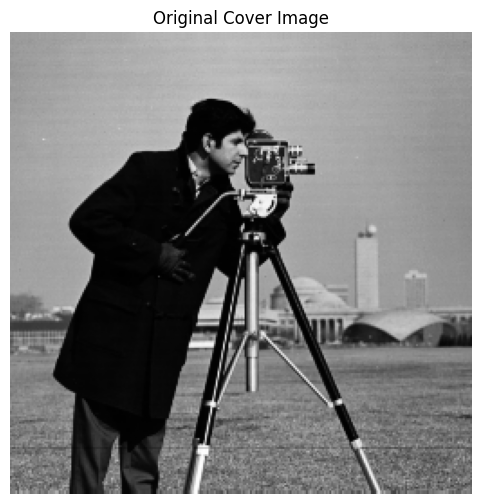

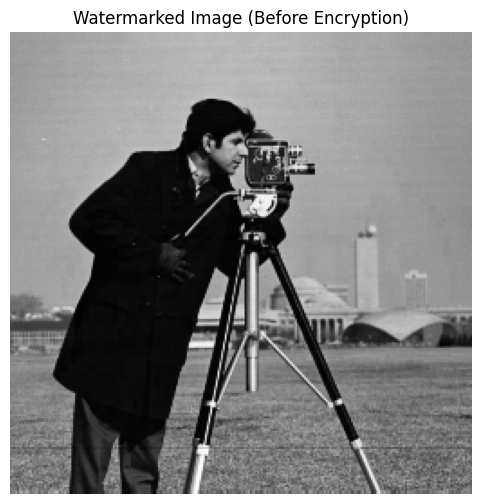

In [25]:
show_image(cover, "Original Cover Image")
show_image(watermarked, "Watermarked Image (Before Encryption)")

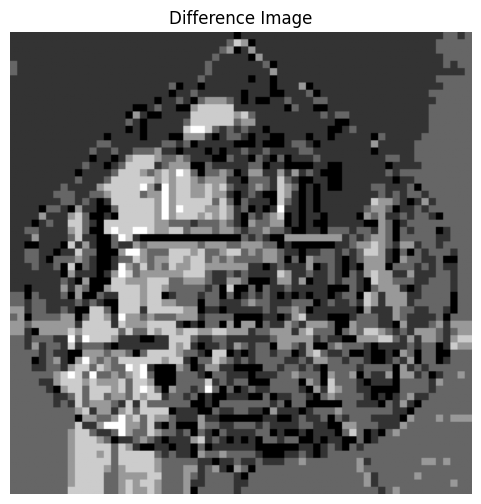

In [26]:
diff = cv2.absdiff(cover, watermarked)
show_image(diff, "Difference Image")

In [29]:
chaos_key = generate_chaos_key(
    watermarked.shape,
    CHAOS_SEED
)

In [30]:
encrypted = np.bitwise_xor(watermarked, chaos_key)


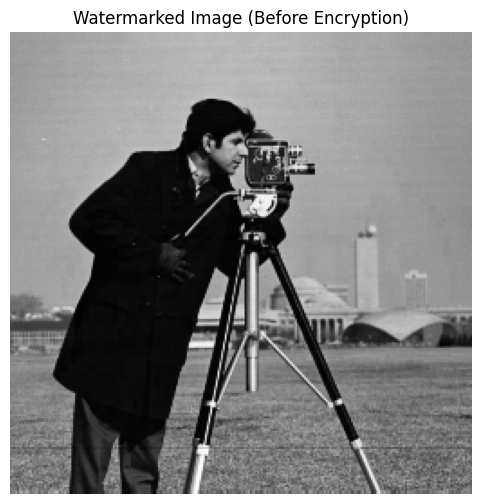

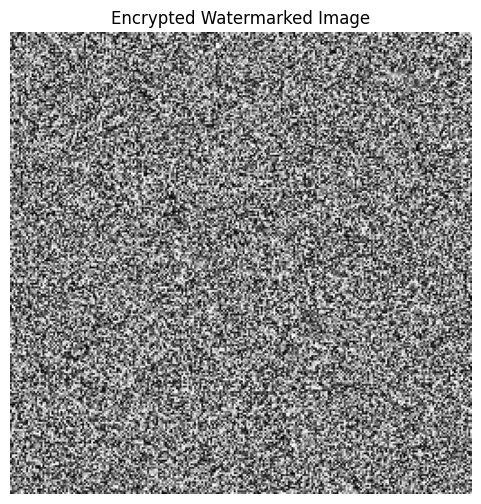

In [31]:
show_image(watermarked, "Watermarked Image (Before Encryption)")
show_image(encrypted, "Encrypted Watermarked Image")


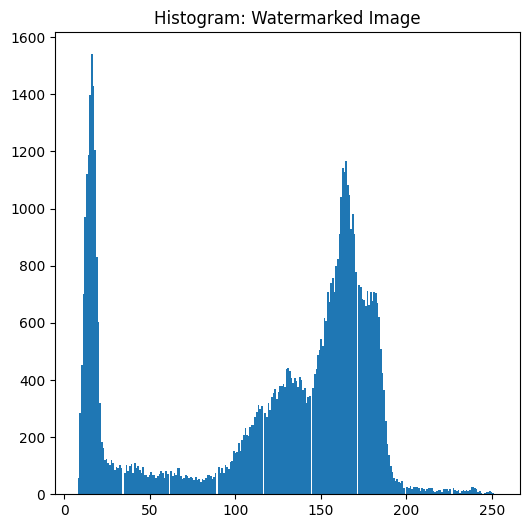

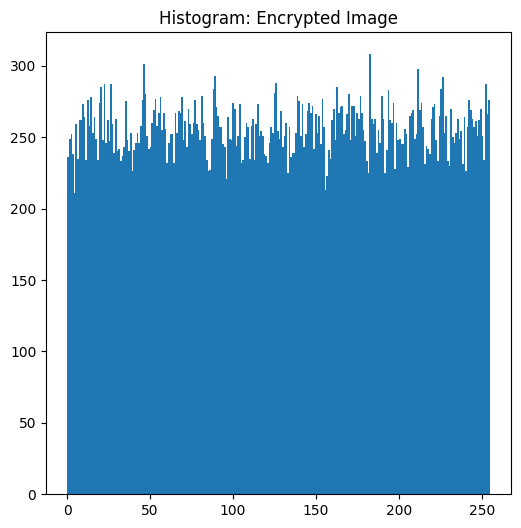

In [32]:
plt.hist(watermarked.flatten(), bins=256)
plt.title("Histogram: Watermarked Image")
plt.show()

plt.hist(encrypted.flatten(), bins=256)
plt.title("Histogram: Encrypted Image")
plt.show()


In [33]:
chaos_key_dec = generate_chaos_key(
    encrypted.shape,
    CHAOS_SEED
)


In [34]:
decrypted = np.bitwise_xor(encrypted, chaos_key_dec)


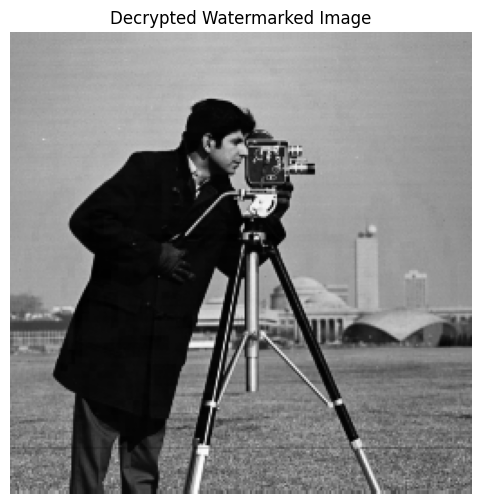

In [35]:
show_image(decrypted, "Decrypted Watermarked Image")


In [36]:
print("Exact recovery:",
      np.array_equal(decrypted, watermarked))


Exact recovery: True


In [37]:
coeffs_decrypted = pywt.wavedec2(
    decrypted.astype(np.double),
    wavelet=WAVELET,
    level=DWT_LEVEL
)

LL2_decrypted = coeffs_decrypted[0]


In [39]:
LL2_wm_extracted = (LL2_decrypted - (K * LL2_cover)) / Q


In [41]:
LL2_wm_extracted_resized = cv2.resize(
    LL2_wm_extracted,
    (LL2_wm_original.shape[1], LL2_wm_original.shape[0]),
    interpolation=cv2.INTER_CUBIC
)


In [42]:
# Create zero detail bands
zero_LH2 = np.zeros_like(LL2_wm_extracted_resized)
zero_HL2 = np.zeros_like(LL2_wm_extracted_resized)
zero_HH2 = np.zeros_like(LL2_wm_extracted_resized)

zero_LH1 = np.zeros_like(LL2_wm_extracted_resized)
zero_HL1 = np.zeros_like(LL2_wm_extracted_resized)
zero_HH1 = np.zeros_like(LL2_wm_extracted_resized)

coeffs_wm_extracted = [
    LL2_wm_extracted_resized,
    (zero_LH2, zero_HL2, zero_HH2),
    (zero_LH1, zero_HL1, zero_HH1)
]


In [44]:
(_, (LH2_wm, HL2_wm, HH2_wm),
    (LH1_wm, HL1_wm, HH1_wm)) = coeffs_wm


In [45]:
zero_LH2 = np.zeros_like(LH2_wm)
zero_HL2 = np.zeros_like(HL2_wm)
zero_HH2 = np.zeros_like(HH2_wm)

zero_LH1 = np.zeros_like(LH1_wm)
zero_HL1 = np.zeros_like(HL1_wm)
zero_HH1 = np.zeros_like(HH1_wm)


In [46]:
LL2_wm_extracted_resized = cv2.resize(
    LL2_wm_extracted,
    (coeffs_wm[0].shape[1], coeffs_wm[0].shape[0]),
    interpolation=cv2.INTER_CUBIC
)


In [47]:
coeffs_wm_extracted = [
    LL2_wm_extracted_resized,
    (zero_LH2, zero_HL2, zero_HH2),
    (zero_LH1, zero_HL1, zero_HH1)
]


In [49]:
watermark_extracted_double = pywt.waverec2(
    coeffs_wm_extracted,
    wavelet=WAVELET
)


In [50]:
for level in coeffs_wm_extracted:
    if isinstance(level, tuple):
        print([b.shape for b in level])
    else:
        print(level.shape)


(75, 104)
[(75, 104), (75, 104), (75, 104)]
[(150, 207), (150, 207), (150, 207)]


In [51]:
watermark_extracted = np.clip(
    watermark_extracted_float,
    0, 255
).astype(np.uint8)


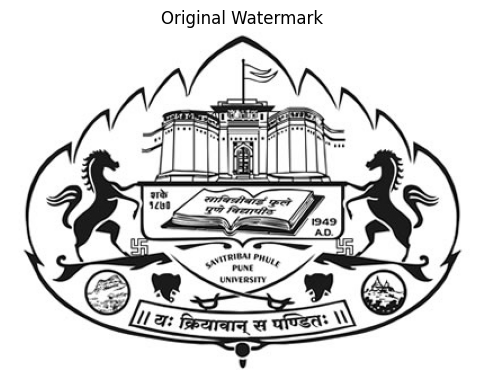

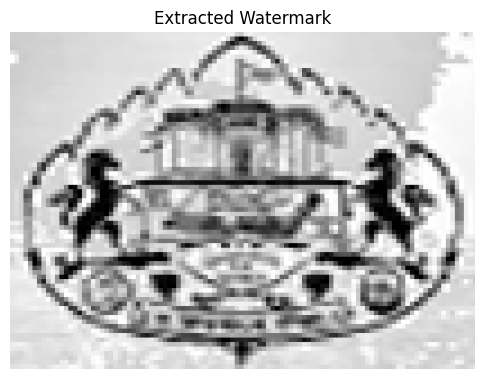

In [52]:
show_image(watermark, "Original Watermark")
show_image(watermark_extracted, "Extracted Watermark")


In [55]:
def compute_psnr(img1, img2):
    mse = np.mean((img1.astype(np.double) - img2.astype(np.double)) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10((255 ** 2) / mse)
psnr_value = compute_psnr(cover, watermarked)
print("PSNR (Cover vs Watermarked):", psnr_value, "dB")


from skimage.metrics import structural_similarity as ssim

ssim_value = ssim(
    cover,
    watermarked,
    data_range=255
)

print("SSIM (Cover vs Watermarked):", ssim_value)


PSNR (Cover vs Watermarked): 41.99846760680885 dB
SSIM (Cover vs Watermarked): 0.9908971342771616
